# Inbalanced Classes
## In this lab, we are going to explore a case of imbalanced classes. 


Like we disussed in class, when we have noisy data, if we are not careful, we can end up fitting our model to the noise in the data and not the 'signal'-- the factors that actually determine the outcome. This is called overfitting, and results in good results in training, and in bad results when the model is applied to real data. Similarly, we could have a model that is too simplistic to accurately model the signal. This produces a model that doesnt work well (ever). 


### Note: before doing the first commit, make sure you don't include the large csv file, either by adding it to .gitignore, or by deleting it.

### First, download the data from: https://www.kaggle.com/ntnu-testimon/paysim1. Import the dataset and provide some discriptive statistics and plots. What do you think will be the important features in determining the outcome?
### Note: don't use the entire dataset, use a sample instead, with n=100000 elements, so your computer doesn't freeze.

         step      type     amount     nameOrig  oldbalanceOrg  \
4644207   330   CASH_IN  607193.64   C104196924    15458649.28   
3800666   281   PAYMENT    3473.75  C1283140808           0.00   
4426240   322  CASH_OUT   66170.69  C1376666142       32803.00   
5788765   401  TRANSFER  335384.26  C2136161445         197.00   
2010701   180   CASH_IN  234392.25   C801137003       20882.00   

         newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  \
4644207     16065842.92  C2020875465      3394537.70      2787344.06        0   
3800666            0.00  M2044695613            0.00            0.00        0   
4426240            0.00    C52514926            0.00        66170.69        0   
5788765            0.00  C2094766437      5311958.61      5647342.87        0   
2010701       255274.25  C1255594470            0.00            0.00        0   

         isFlaggedFraud  
4644207               0  
3800666               0  
4426240               0  
5788765     

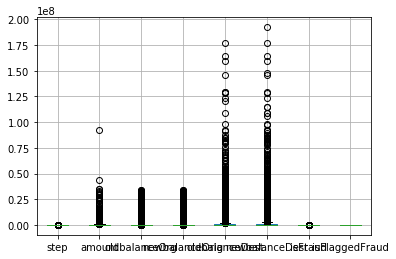

In [1]:
# Your code here
import pandas as pd
import random


data = pd.read_csv("data.csv")
sample = data.sample(n=100000,random_state=0)
print(sample.head())
print(sample.describe())
sample.boxplot()

### What is the distribution of the outcome? 

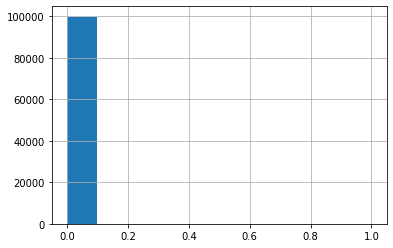

In [2]:
# Your response here
sample['isFraud'].hist()

In [3]:
sample.groupby(by='isFraud').count()['step']

isFraud
0    99876
1      124
Name: step, dtype: int64

### Clean the dataset. How are you going to integrate the time variable? Do you think the step (integer) coding in which it is given is appropriate?

In [4]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 4644207 to 2405411
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            100000 non-null  int64  
 1   type            100000 non-null  object 
 2   amount          100000 non-null  float64
 3   nameOrig        100000 non-null  object 
 4   oldbalanceOrg   100000 non-null  float64
 5   newbalanceOrig  100000 non-null  float64
 6   nameDest        100000 non-null  object 
 7   oldbalanceDest  100000 non-null  float64
 8   newbalanceDest  100000 non-null  float64
 9   isFraud         100000 non-null  int64  
 10  isFlaggedFraud  100000 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 9.2+ MB


In [5]:
sample.groupby(by='step').count()

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
step,,,,,,,,,,
1,37,37,37,37,37,37,37,37,37,37
2,14,14,14,14,14,14,14,14,14,14
3,7,7,7,7,7,7,7,7,7,7
4,12,12,12,12,12,12,12,12,12,12
5,15,15,15,15,15,15,15,15,15,15
...,...,...,...,...,...,...,...,...,...,...
715,34,34,34,34,34,34,34,34,34,34
717,11,11,11,11,11,11,11,11,11,11
718,17,17,17,17,17,17,17,17,17,17


In [6]:
sample.corr()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
step,1.000000,0.024472,-0.008811,-0.009057,0.025140,0.024132,0.031504,NaN
amount,0.024472,1.000000,-0.003429,-0.009119,0.266745,0.457819,0.078697,NaN
oldbalanceOrg,-0.008811,-0.003429,1.000000,0.998667,0.069099,0.043878,0.010624,NaN
newbalanceOrig,-0.009057,-0.009119,0.998667,1.000000,0.070804,0.043358,-0.010201,NaN
oldbalanceDest,0.025140,0.266745,0.069099,0.070804,1.000000,0.968653,-0.005207,NaN
newbalanceDest,0.024132,0.457819,0.043878,0.043358,0.968653,1.000000,0.004631,NaN
isFraud,0.031504,0.078697,0.010624,-0.010201,-0.005207,0.004631,1.000000,NaN
isFlaggedFraud,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
import numpy as np
dic_h={}
for i in range(1,50,1):
    dic_h[i]=i*24-24

sample["step"]=sample["step"].apply(lambda x: x-dic_h[np.ceil(x/24)])

In [8]:
sample.corr()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
step,1.000000,-0.034901,0.000773,0.000722,-0.009599,-0.016111,-0.018059,NaN
amount,-0.034901,1.000000,-0.003429,-0.009119,0.266745,0.457819,0.078697,NaN
oldbalanceOrg,0.000773,-0.003429,1.000000,0.998667,0.069099,0.043878,0.010624,NaN
newbalanceOrig,0.000722,-0.009119,0.998667,1.000000,0.070804,0.043358,-0.010201,NaN
oldbalanceDest,-0.009599,0.266745,0.069099,0.070804,1.000000,0.968653,-0.005207,NaN
newbalanceDest,-0.016111,0.457819,0.043878,0.043358,0.968653,1.000000,0.004631,NaN
isFraud,-0.018059,0.078697,0.010624,-0.010201,-0.005207,0.004631,1.000000,NaN
isFlaggedFraud,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
sample.drop('newbalanceOrig',axis=1,inplace=True)
sample.drop('isFlaggedFraud',axis=1,inplace=True)
sample.drop('newbalanceDest',axis=1,inplace=True)
sample.drop('nameOrig',axis=1,inplace=True)
sample.drop('nameDest',axis=1,inplace=True)

In [10]:
sample.corr()

,step,amount,oldbalanceOrg,oldbalanceDest,isFraud
step,1.000000,-0.034901,0.000773,-0.009599,-0.018059
amount,-0.034901,1.000000,-0.003429,0.266745,0.078697
oldbalanceOrg,0.000773,-0.003429,1.000000,0.069099,0.010624
oldbalanceDest,-0.009599,0.266745,0.069099,1.000000,-0.005207
isFraud,-0.018059,0.078697,0.010624,-0.005207,1.000000


In [11]:
sample.head()

,step,type,amount,oldbalanceOrg,oldbalanceDest,isFraud
4644207,18,CASH_IN,607193.64,15458649.28,3394537.70,0
3800666,17,PAYMENT,3473.75,0.00,0.00,0
4426240,10,CASH_OUT,66170.69,32803.00,0.00,0
5788765,17,TRANSFER,335384.26,197.00,5311958.61,0
2010701,12,CASH_IN,234392.25,20882.00,0.00,0


In [12]:
sample = pd.get_dummies(sample, columns=['type'],drop_first=True)

In [13]:
sample.head()

,step,amount,oldbalanceOrg,oldbalanceDest,isFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
4644207,18,607193.64,15458649.28,3394537.70,0,0,0,0,0
3800666,17,3473.75,0.00,0.00,0,0,0,1,0
4426240,10,66170.69,32803.00,0.00,0,1,0,0,0
5788765,17,335384.26,197.00,5311958.61,0,0,0,0,1
2010701,12,234392.25,20882.00,0.00,0,0,0,0,0


In [14]:
features = sample.drop('isFraud',axis=1)

In [15]:
target = sample['isFraud']

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2,random_state=0)

In [17]:
#from imblearn.over_sampling import SMOTE
#sm = SMOTE(random_state=0)
#X_train, y_train = sm.fit_sample(X_train,y_train)
 #Recall on 1 went from 67% to 0% with SMOTE sampling :O

### Run a logisitc regression classifier and evaluate its accuracy.

In [24]:
# Your code here
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)
#predictions: test data
y_pred = logistic_model.predict(X_test)


In [25]:
# Function to score a CLASSIFICATION exercise
def classification_score(X_test=X_test, y_test=y_test):
    y_pred = model.predict(X_test)
    # compare predictions to actual answers
    print('Confusion matrix')
    print(confusion_matrix(y_pred,y_test))
    print('-------------------------------------------------------')
    # accuracy_score
    # fitted X_test data vs. y_test data (actual answer)
    print('Accuracy score')
    print(accuracy_score(y_pred,y_test))
    print('-------------------------------------------------------')
    # classification report
    print('Classification report')
    print(classification_report(y_pred,y_test))
    return
classification_score()

Confusion matrix
[[19971    26]
 [    1     2]]
-------------------------------------------------------
Accuracy score
0.99865
-------------------------------------------------------
Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19997
           1       0.07      0.67      0.13         3

    accuracy                           1.00     20000
   macro avg       0.54      0.83      0.56     20000
weighted avg       1.00      1.00      1.00     20000



### Now pick a model of your choice and evaluate its accuracy.

In [26]:
# Your code here

# Random forest
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state=0)
from sklearn.ensemble import RandomForestClassifier

# create an instance of the model
model = RandomForestClassifier()

# fit the model
model.fit(X_train, y_train)

# predict for test 
y_pred = model.predict(X_test)

classification_score()



Confusion matrix
[[19970    15]
 [    2    13]]
-------------------------------------------------------
Accuracy score
0.99915
-------------------------------------------------------
Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19985
           1       0.46      0.87      0.60        15

    accuracy                           1.00     20000
   macro avg       0.73      0.93      0.80     20000
weighted avg       1.00      1.00      1.00     20000



In [28]:
#Now with synthetic sampling
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state=0)
from imblearn.over_sampling import SMOTE

sm=SMOTE(random_state=0)
X_train,y_train=sm.fit_sample(X_train,y_train)

# create an instance of the model
model = RandomForestClassifier()

# fit the model
model.fit(X_train, y_train)

# predict for test 
y_pred = model.predict(X_test)

classification_score()

Confusion matrix
[[19915    11]
 [   57    17]]
-------------------------------------------------------
Accuracy score
0.9966
-------------------------------------------------------
Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19926
           1       0.61      0.23      0.33        74

    accuracy                           1.00     20000
   macro avg       0.80      0.61      0.67     20000
weighted avg       1.00      1.00      1.00     20000



In [30]:
#SMOTE is not working. Let us try oversampling

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state=0)
sample_concat=pd.concat([X_train,y_train],axis=1)

#separate minority and majority classes
not_fraud=sample_concat[sample_concat["isFraud"]==0] #majority class
fraud=sample_concat[sample_concat["isFraud"]==1]

from sklearn.utils import resample

fraud_upsampled=resample(fraud,
                        replace=True, #sample with replacement
                        n_samples=len(not_fraud), # match number in majority class
                        random_state=0
                        )
sample_concat2=pd.concat([not_fraud,fraud_upsampled])

X_train = sample_concat2.drop(['isFraud'], axis =1) #features
y_train = sample_concat2['isFraud'] #target


# create an instance of the model
model = RandomForestClassifier()

# fit the model
model.fit(X_train, y_train)

# predict for test 
y_pred = model.predict(X_test)

classification_score()



Confusion matrix
[[19967    10]
 [    5    18]]
-------------------------------------------------------
Accuracy score
0.99925
-------------------------------------------------------
Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19977
           1       0.64      0.78      0.71        23

    accuracy                           1.00     20000
   macro avg       0.82      0.89      0.85     20000
weighted avg       1.00      1.00      1.00     20000



### Which model worked better and how do you know?

In [21]:
# Your response here

#Sampling does not show any improvement. Both in random forest and logistic regression. No idea why.

#Best model is random forest (as usual) with no change in the sample.

### Note: before doing the first commit, make sure you don't include the large csv file, either by adding it to .gitignore, or by deleting it.